In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import struct
from array import array
from os.path  import join
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [332]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test) 

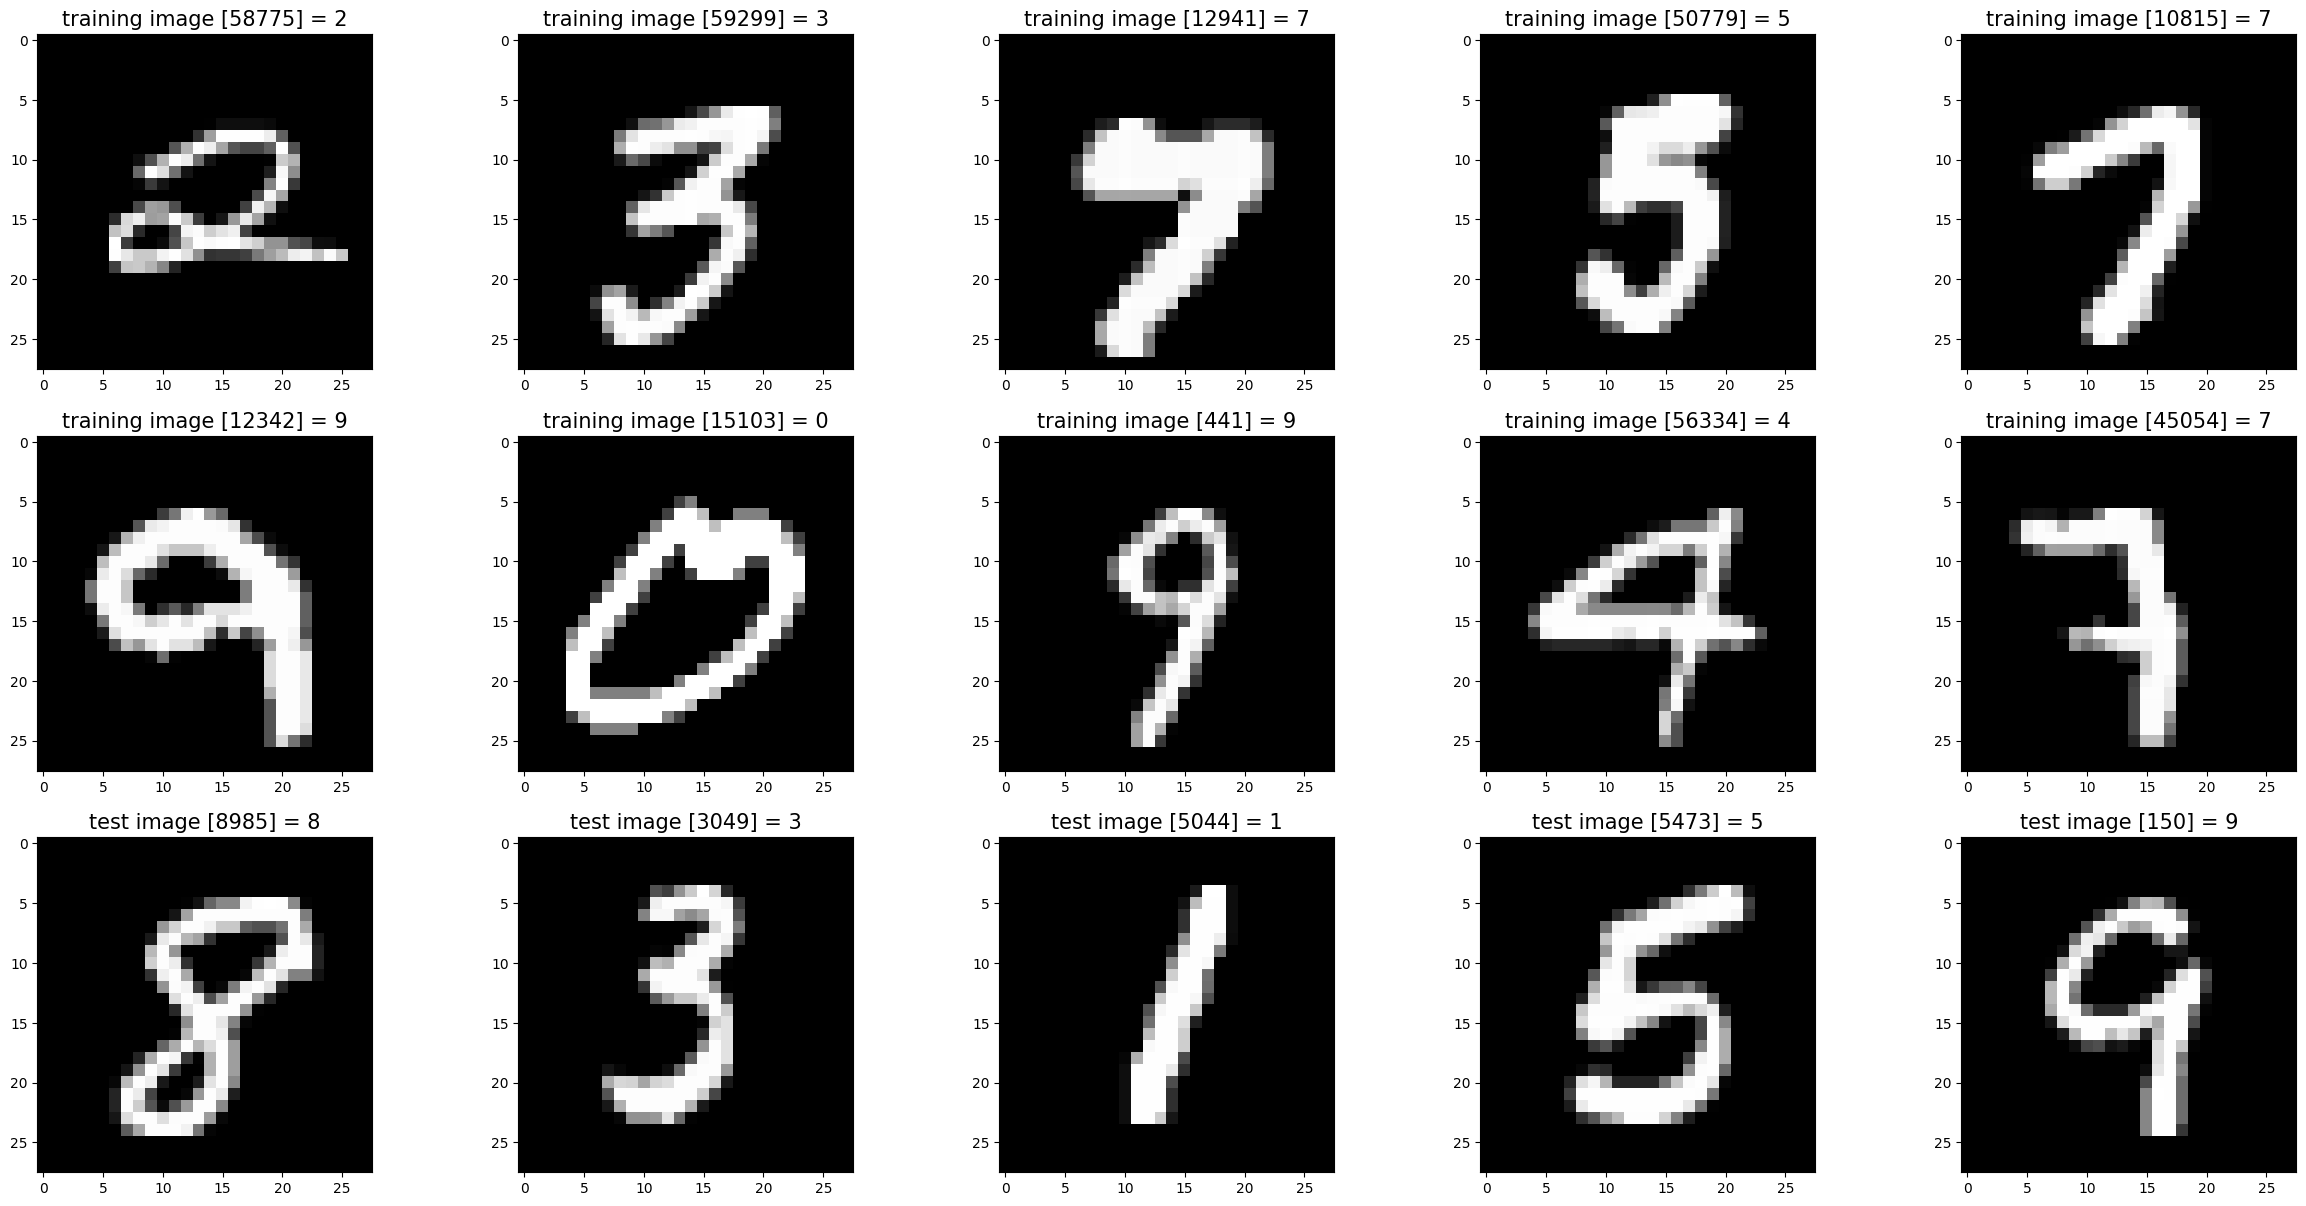

In [333]:
input_path = './mnist'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = np.random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = np.random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [334]:
for i in range(len(x_train)):
    x_train[i] = np.hstack(x_train[i], dtype=np.float32) / 255

for i in range(len(x_test)):
    x_test[i] = np.hstack(x_test[i], dtype=np.float32) / 255

In [335]:
class FCN(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super().__init__()
        self.linear_layers = (
            [nn.Linear(input_size, hidden_sizes[0], dtype=torch.float)] 
            + [nn.Linear(hidden_sizes[i], hidden_sizes[i + 1], dtype=torch.float) 
               for i in range(len(hidden_sizes) - 1)]
            )
        self.output = nn.Linear(hidden_sizes[-1], num_classes, dtype=torch.float)
        
    def forward(self, x):
        for i in range(len(self.linear_layers)):
            x = self.linear_layers[i](x)
            x = F.leaky_relu(x)

        x = F.softmax(self.output(x), dim=1)
        return x


In [336]:
train_loader = DataLoader(list(zip(x_train, y_train)), batch_size=128, shuffle=True)
test_loader = DataLoader(list(zip(x_test, y_test)), batch_size=128, shuffle=True)

In [352]:
model = FCN(input_size=784, hidden_sizes=[256, 128], num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, min_lr=1e-5)
criterion = nn.CrossEntropyLoss()

In [350]:
def train(model, optimizer, criterion, train_loader):
    losses = []
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        losses.append(loss.mean())
        # print(outputs, labels)
        loss.backward()
        optimizer.step()
    
    return losses


def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            # print(torch.cat([predicted.unsqueeze(0).T, labels.unsqueeze(0).T], 1)[:20])
            total += predicted.size(0)
            # print(predicted.shape[0])
            correct += (predicted == labels).sum().item()
            # print((predicted == labels).sum().item())

    return correct / total


In [356]:
losses = []
for epoch in range(100):
    loss = train(model, optimizer, criterion, train_loader)
    losses.append((sum(loss) / len(loss)).item())
    
    metric = evaluate(model, test_loader)
    scheduler.step(1 - metric)
    print(epoch, metric, scheduler.get_last_lr()[0])


0 0.8758 0.05
1 0.8807 0.05
2 0.8803 0.05
3 0.8793 0.05
4 0.8817 0.05
5 0.8786 0.05
6 0.8791 0.05
7 0.8793 0.05
8 0.8761 0.05
9 0.8814 0.05
10 0.8794 0.025
11 0.8815 0.025
12 0.8835 0.025
13 0.8818 0.025
14 0.883 0.025
15 0.8819 0.025
16 0.8829 0.025
17 0.8826 0.025
18 0.8825 0.0125
19 0.883 0.0125
20 0.8836 0.0125
21 0.8834 0.0125
22 0.8827 0.0125
23 0.8819 0.0125
24 0.8827 0.0125
25 0.8821 0.0125
26 0.8828 0.00625
27 0.8826 0.00625
28 0.8827 0.00625
29 0.8826 0.00625
30 0.8828 0.00625
31 0.8835 0.00625
32 0.8831 0.003125
33 0.8825 0.003125
34 0.8828 0.003125
35 0.8823 0.003125
36 0.8827 0.003125
37 0.8829 0.003125
38 0.8828 0.0015625
39 0.8829 0.0015625
40 0.8838 0.0015625
41 0.8831 0.0015625
42 0.8827 0.0015625
43 0.8828 0.0015625
44 0.8832 0.0015625
45 0.8837 0.0015625
46 0.8831 0.00078125
47 0.883 0.00078125
48 0.8831 0.00078125
49 0.8831 0.00078125
50 0.8829 0.00078125
51 0.8831 0.00078125
52 0.8833 0.000390625
53 0.8829 0.000390625
54 0.883 0.000390625
55 0.8829 0.000390625
56 0

In [357]:
_, y_pred = torch.max(model(torch.tensor(x_test)), 1)
y_pred

tensor([7, 2, 1,  ..., 4, 5, 6])

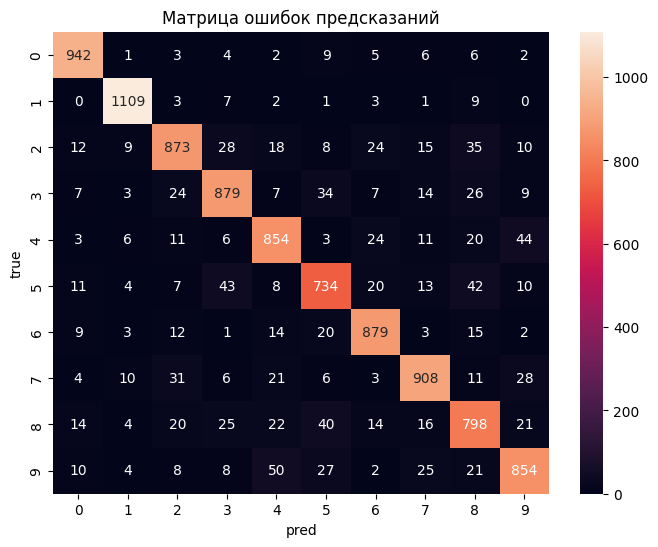

In [358]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), fmt='d', annot=True)
plt.xlabel('pred')
plt.ylabel('true')
plt.title('Матрица ошибок предсказаний');

In [359]:
(accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='weighted'), 
 recall_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted'))

(0.883, 0.8827063628994128, 0.883, 0.8827416343704454)

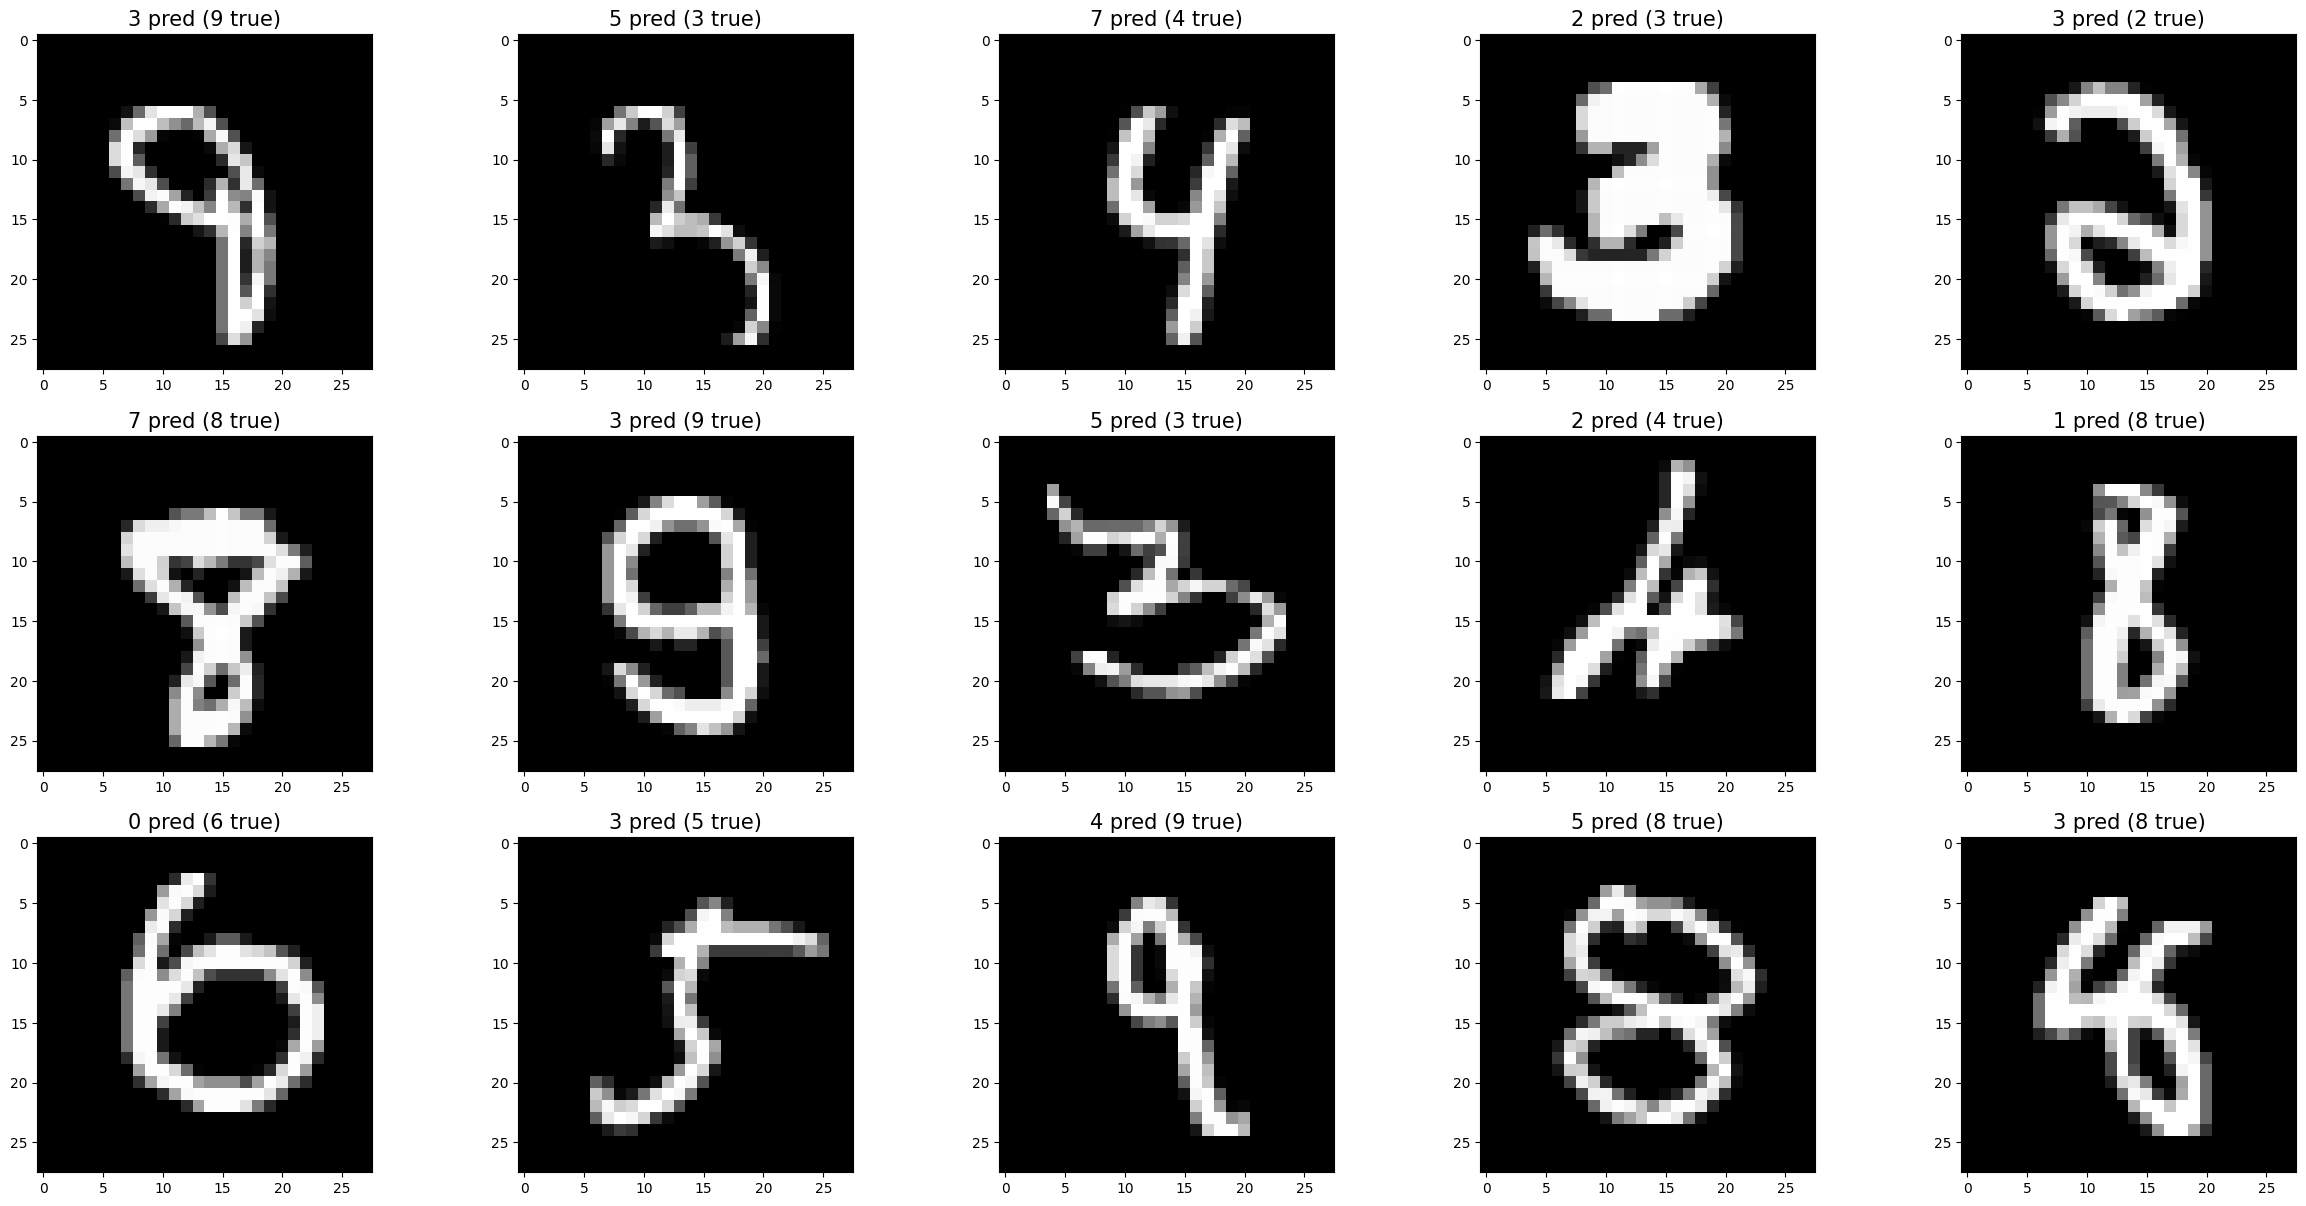

In [364]:
imgs, tiles = [], []
for i, tp in enumerate(np.equal(y_pred, y_test)):
    if not tp and len(imgs) < 30:
        imgs.append(x_test[i].reshape((28, 28)))
        tiles.append(f"{y_pred[i]} pred ({y_test[i]} true)")

show_images(imgs[15:], tiles[15:])

In [ ]:
for layer in model.linear_layers + [model.output]:
    print('Веса слоя')
    print(layer.weight, end='\n\n')
    print('Смещения')
    print(layer.bias, end='\n\n\n')


Веса слоя
Parameter containing:
tensor([[ 0.0152,  0.0195, -0.0052,  ...,  0.0308,  0.0099,  0.0141],
        [-0.0183, -0.0272,  0.0285,  ..., -0.0102,  0.0322, -0.0300],
        [ 0.0088,  0.0301,  0.0034,  ...,  0.0169, -0.0019, -0.0021],
        ...,
        [-0.0008,  0.0050,  0.0129,  ...,  0.0293, -0.0198, -0.0245],
        [-0.0237, -0.0164,  0.0302,  ..., -0.0038, -0.0224,  0.0238],
        [ 0.0140,  0.0216, -0.0169,  ...,  0.0214,  0.0320, -0.0096]],
       requires_grad=True)

Смещения
Parameter containing:
tensor([-2.8995e-02,  1.8966e-04,  1.1799e-02,  3.0386e-02,  7.8963e-03,
         2.4763e-04,  1.8450e-02,  1.0225e-02, -6.3760e-03, -6.4891e-03,
        -2.3953e-02, -3.2388e-03, -3.0491e-02,  1.8334e-02,  1.3945e-02,
         2.3140e-02, -4.2466e-03,  2.8372e-02, -1.8984e-02, -9.9561e-03,
        -2.0014e-02,  1.3645e-02,  2.7444e-02, -4.8364e-03,  1.1228e-02,
        -9.0411e-03, -1.5134e-02, -4.9006e-03, -3.0394e-02, -7.2478e-03,
         9.9491e-03,  2.5100e-02,  1.

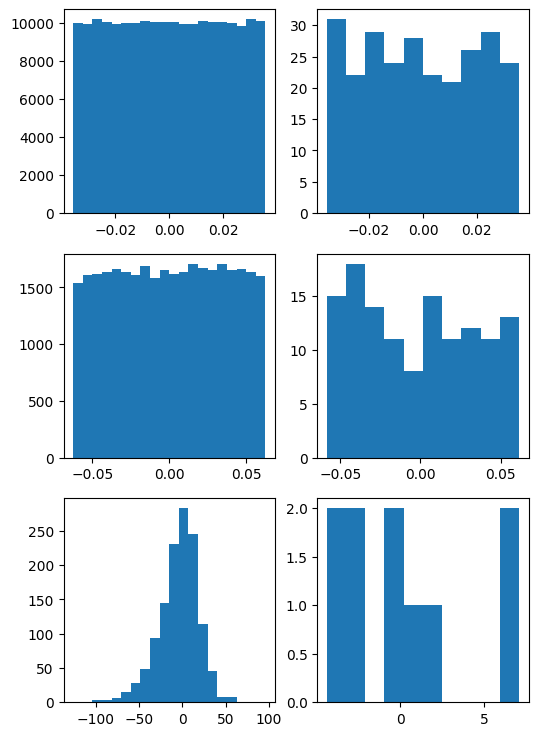

In [376]:
fig, ax = plt.subplots(3, 2)
fig.set_figheight(9)
fig.set_figwidth(6)
for i, layer in enumerate(model.linear_layers + [model.output]):
    ax[i, 0].hist(layer.weight.detach().numpy().flatten(), bins=20)
    ax[i, 1].hist(layer.bias.detach().numpy().flatten())

plt.show()